2. LSTM Autoencoder

In [2]:
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import LSTMCell

import numpy as np
import pandas as pd
import random as rd
import time
import math
import csv
import os

C:\Users\dsba\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
class LSTMAutoencoder(object):

    """Usage:
    ae = LSTMAutoencoder(hidden_num, inputs)
    sess.run(ae.train)
  """

    def __init__(
        self,
        hidden_num,
        inputs,
        cell=None,
        optimizer=None,
        reverse=False,
        decode_without_input=False,
        ):
        """
    Args:
      hidden_num : number of hidden elements of each LSTM unit.
      inputs : a list of input tensors with size 
              (batch_num x elem_num)
      cell : an rnn cell object (the default option 
            is `tf.python.ops.rnn_cell.LSTMCell`)
      optimizer : optimizer for rnn (the default option is
              `tf.train.AdamOptimizer`)
      reverse : Option to decode in reverse order.
      decode_without_input : Option to decode without input.
    """

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]

        if cell is None:
            self._enc_cell = LSTMCell(hidden_num)
            self._dec_cell = LSTMCell(hidden_num)
        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight'
                    )
            dec_bias_ = tf.Variable(tf.constant(0.1,
                                    shape=[self.elem_num],
                                    dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),
                              dtype=tf.float32) for _ in
                              range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state,
                        dtype=tf.float32)
                if reverse:
                    dec_outputs = dec_outputs[::-1]
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,
                        2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),
                        [self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_
            else:

                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),
                        dtype=tf.float32)
                dec_outputs = []
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) = \
                        self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) \
                        + dec_bias_
                    dec_outputs.append(dec_input_)
                if reverse:
                    dec_outputs = dec_outputs[::-1]
                self.output_ = tf.transpose(tf.stack(dec_outputs), [1,
                        0, 2])

        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_
                                   - self.output_))
        tf.summary.scalar('loss',self.loss)
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 0.1
        learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                             global_step,
                                             100, 0.8, staircase=True)
        if optimizer is None:
            self.train = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        else:
            self.train = optimizer.minimize(self.loss)

In [5]:
from numpy import genfromtxt
from sklearn.preprocessing import StandardScaler, scale
import sklearn
import csv
#with open("Total_index.csv", newline='') as data:
data=genfromtxt('Total_index.csv', delimiter=',')
data=data[1:,1:]
data=sklearn.preprocessing.scale(data)
#data= np.array(data)



C:\Users\dsba\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [11]:
(loss_val)

2.3156955

In [27]:
#decay no
tf.reset_default_graph()
tf.set_random_seed(2016)
np.random.seed(2016)
batch_num = 1
hidden_num = 15
step_num = 25
elem_num = 385
iteration = 3205

# placeholder list
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
ae = LSTMAutoencoder(hidden_num, p_inputs, cell=cell, decode_without_input=False)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(iteration):
        input1 =data[i:i+25,]
        input1=input1.reshape([1,25,385])
#        for j in range(1,26):
#            input1=np.vstack([input1,data[i+j:i+j+25,].reshape([1,25,385])])
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: input1})
                             
        print('iter %d:' % (i + 1), loss_val)

    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: input1})
    print('train result :')
    print('input :', input_[0, :, :].flatten())
    print('output :', output_[0, :, :].flatten())

iter 1: 3.3883429
iter 2: 2.5137103
iter 3: 2.5683157
iter 4: 2.2648602
iter 5: 2.1453724
iter 6: 2.063475
iter 7: 1.9910625
iter 8: 1.94468
iter 9: 1.8896463
iter 10: 1.8657043
iter 11: 1.8489497
iter 12: 1.8214713
iter 13: 1.8011063
iter 14: 1.7897778
iter 15: 1.7830997
iter 16: 1.7792795
iter 17: 1.7755424
iter 18: 1.7713474
iter 19: 1.7668684
iter 20: 1.7628783
iter 21: 1.7612411
iter 22: 1.7563523
iter 23: 1.7538657
iter 24: 1.7505221
iter 25: 1.746644
iter 26: 1.7452066
iter 27: 1.7460377
iter 28: 1.746404
iter 29: 1.7417783
iter 30: 1.7481169
iter 31: 1.7414649
iter 32: 1.7417263
iter 33: 1.7382082
iter 34: 1.7335008
iter 35: 1.7303846
iter 36: 1.7286271
iter 37: 1.726355
iter 38: 1.7181658
iter 39: 1.7142514
iter 40: 1.710172
iter 41: 1.7041534
iter 42: 1.6973494
iter 43: 1.6914105
iter 44: 1.6854286
iter 45: 1.6781557
iter 46: 1.6705406
iter 47: 1.6624376
iter 48: 1.6538029
iter 49: 1.6452546
iter 50: 1.6369202
iter 51: 1.6287193
iter 52: 1.621504
iter 53: 1.613571
iter 54: 1.

iter 429: 0.7821249
iter 430: 0.7822785
iter 431: 0.7818242
iter 432: 0.7813987
iter 433: 0.78157383
iter 434: 0.78362036
iter 435: 0.7858342
iter 436: 0.7878646
iter 437: 0.7897755
iter 438: 0.7916542
iter 439: 0.793096
iter 440: 0.7939223
iter 441: 0.7951112
iter 442: 0.79673547
iter 443: 0.7998935
iter 444: 0.8018333
iter 445: 0.803765
iter 446: 0.8052959
iter 447: 0.80666876
iter 448: 0.80771035
iter 449: 0.8087706
iter 450: 0.8098441
iter 451: 0.8110393
iter 452: 0.8120763
iter 453: 0.8133943
iter 454: 0.8141474
iter 455: 0.8148392
iter 456: 0.81544477
iter 457: 0.8158443
iter 458: 0.8155002
iter 459: 0.81436855
iter 460: 0.8132331
iter 461: 0.8122405
iter 462: 0.81775784
iter 463: 0.8235613
iter 464: 0.8288331
iter 465: 0.8337732
iter 466: 0.8387632
iter 467: 0.84342325
iter 468: 0.84673035
iter 469: 0.8513469
iter 470: 0.8555338
iter 471: 0.8625836
iter 472: 0.86756533
iter 473: 0.8727806
iter 474: 0.87779605
iter 475: 0.8835056
iter 476: 0.88985807
iter 477: 0.8944294
iter 478:

iter 851: 0.28029123
iter 852: 0.27627343
iter 853: 0.27484798
iter 854: 0.27494138
iter 855: 0.2744296
iter 856: 0.27376005
iter 857: 0.27271238
iter 858: 0.2714604
iter 859: 0.27227983
iter 860: 0.27351573
iter 861: 0.2755642
iter 862: 0.27769446
iter 863: 0.27933866
iter 864: 0.2810261
iter 865: 0.28282586
iter 866: 0.2836514
iter 867: 0.2849063
iter 868: 0.28627154
iter 869: 0.2876267
iter 870: 0.28892288
iter 871: 0.2896037
iter 872: 0.2904603
iter 873: 0.29135823
iter 874: 0.29234868
iter 875: 0.29346818
iter 876: 0.2944404
iter 877: 0.2953563
iter 878: 0.29662448
iter 879: 0.29710105
iter 880: 0.29820645
iter 881: 0.29999664
iter 882: 0.30190548
iter 883: 0.30416927
iter 884: 0.3040738
iter 885: 0.3033282
iter 886: 0.30199283
iter 887: 0.3005829
iter 888: 0.3026448
iter 889: 0.30580488
iter 890: 0.30687326
iter 891: 0.30790383
iter 892: 0.30840412
iter 893: 0.3087844
iter 894: 0.30912575
iter 895: 0.3098958
iter 896: 0.31008014
iter 897: 0.3101546
iter 898: 0.31007364
iter 899: 

iter 1240: 0.33836266
iter 1241: 0.33621153
iter 1242: 0.33420163
iter 1243: 0.33237728
iter 1244: 0.3307285
iter 1245: 0.32895684
iter 1246: 0.32732815
iter 1247: 0.32543245
iter 1248: 0.32411206
iter 1249: 0.32291922
iter 1250: 0.32260782
iter 1251: 0.32244956
iter 1252: 0.3224298
iter 1253: 0.32182002
iter 1254: 0.32119042
iter 1255: 0.32085353
iter 1256: 0.320195
iter 1257: 0.32021433
iter 1258: 0.32010072
iter 1259: 0.3201117
iter 1260: 0.3205042
iter 1261: 0.32096192
iter 1262: 0.32153967
iter 1263: 0.32188323
iter 1264: 0.32221067
iter 1265: 0.3227698
iter 1266: 0.32321358
iter 1267: 0.32352412
iter 1268: 0.32357153
iter 1269: 0.3239101
iter 1270: 0.32368657
iter 1271: 0.32341588
iter 1272: 0.32369056
iter 1273: 0.32345745
iter 1274: 0.32332718
iter 1275: 0.3230675
iter 1276: 0.32257402
iter 1277: 0.3218112
iter 1278: 0.32247487
iter 1279: 0.32248947
iter 1280: 0.32244426
iter 1281: 0.3220229
iter 1282: 0.32172558
iter 1283: 0.3215242
iter 1284: 0.32047155
iter 1285: 0.31665334


iter 1625: 0.32619995
iter 1626: 0.32650948
iter 1627: 0.32664576
iter 1628: 0.32690758
iter 1629: 0.3275656
iter 1630: 0.32777986
iter 1631: 0.3274029
iter 1632: 0.32737818
iter 1633: 0.32734174
iter 1634: 0.32716796
iter 1635: 0.32740515
iter 1636: 0.32797006
iter 1637: 0.32812977
iter 1638: 0.32802242
iter 1639: 0.3281736
iter 1640: 0.32843772
iter 1641: 0.32832125
iter 1642: 0.32838082
iter 1643: 0.3289344
iter 1644: 0.32934594
iter 1645: 0.32896757
iter 1646: 0.32849017
iter 1647: 0.3280351
iter 1648: 0.3273336
iter 1649: 0.32653087
iter 1650: 0.3281629
iter 1651: 0.33030725
iter 1652: 0.3320278
iter 1653: 0.3334632
iter 1654: 0.3346724
iter 1655: 0.33598784
iter 1656: 0.33748403
iter 1657: 0.3388107
iter 1658: 0.34035006
iter 1659: 0.3417373
iter 1660: 0.34332666
iter 1661: 0.3449703
iter 1662: 0.34729138
iter 1663: 0.34942514
iter 1664: 0.35115892
iter 1665: 0.3528099
iter 1666: 0.3539273
iter 1667: 0.35542998
iter 1668: 0.3564573
iter 1669: 0.3578971
iter 1670: 0.3595291
iter 1

iter 2021: 0.69813395
iter 2022: 0.70448667
iter 2023: 0.7108794
iter 2024: 0.71818286
iter 2025: 0.72614205
iter 2026: 0.73429435
iter 2027: 0.7423368
iter 2028: 0.74942976
iter 2029: 0.7564887
iter 2030: 0.76395994
iter 2031: 0.77115566
iter 2032: 0.7790994
iter 2033: 0.7866642
iter 2034: 0.7935754
iter 2035: 0.7999432
iter 2036: 0.80630654
iter 2037: 0.8123735
iter 2038: 0.81821305
iter 2039: 0.824084
iter 2040: 0.8226816
iter 2041: 0.8213488
iter 2042: 0.8195151
iter 2043: 0.81762254
iter 2044: 0.8161962
iter 2045: 0.81480724
iter 2046: 0.8121725
iter 2047: 0.80652785
iter 2048: 0.80225176
iter 2049: 0.79870605
iter 2050: 0.79456604
iter 2051: 0.7910475
iter 2052: 0.78758
iter 2053: 0.7845593
iter 2054: 0.7789119
iter 2055: 0.7729754
iter 2056: 0.76773006
iter 2057: 0.7623771
iter 2058: 0.7597221
iter 2059: 0.7569018
iter 2060: 0.7536034
iter 2061: 0.7517744
iter 2062: 0.75074273
iter 2063: 0.74993265
iter 2064: 0.7481969
iter 2065: 0.7463171
iter 2066: 0.74971634
iter 2067: 0.7471

iter 2414: 0.6744778
iter 2415: 0.6727154
iter 2416: 0.672303
iter 2417: 0.6713583
iter 2418: 0.6699282
iter 2419: 0.6691644
iter 2420: 0.6683358
iter 2421: 0.6667279
iter 2422: 0.6646726
iter 2423: 0.66367173
iter 2424: 0.6624463
iter 2425: 0.66116023
iter 2426: 0.66036534
iter 2427: 0.6597021
iter 2428: 0.65921074
iter 2429: 0.65263253
iter 2430: 0.6467671
iter 2431: 0.6416689
iter 2432: 0.64001834
iter 2433: 0.6386314
iter 2434: 0.63695043
iter 2435: 0.63378435
iter 2436: 0.63228124
iter 2437: 0.6308978
iter 2438: 0.630709
iter 2439: 0.6292694
iter 2440: 0.6291712
iter 2441: 0.6274133
iter 2442: 0.631213
iter 2443: 0.632232
iter 2444: 0.63587254
iter 2445: 0.6389992
iter 2446: 0.6412533
iter 2447: 0.6451936
iter 2448: 0.6479217
iter 2449: 0.6496905
iter 2450: 0.6505796
iter 2451: 0.65304446
iter 2452: 0.65565205
iter 2453: 0.6583825
iter 2454: 0.6597162
iter 2455: 0.6621124
iter 2456: 0.6646848
iter 2457: 0.66670537
iter 2458: 0.6686597
iter 2459: 0.6709361
iter 2460: 0.6737255
iter

iter 2809: 0.8179825
iter 2810: 0.82133055
iter 2811: 0.8240532
iter 2812: 0.826351
iter 2813: 0.82917553
iter 2814: 0.8310011
iter 2815: 0.8327391
iter 2816: 0.8352386
iter 2817: 0.83705074
iter 2818: 0.8385518
iter 2819: 0.839789
iter 2820: 0.8418034
iter 2821: 0.8434838
iter 2822: 0.84577763
iter 2823: 0.8480664
iter 2824: 0.85011333
iter 2825: 0.851924
iter 2826: 0.8541372
iter 2827: 0.85576767
iter 2828: 0.8580488
iter 2829: 0.85904366
iter 2830: 0.86056066
iter 2831: 0.86194754
iter 2832: 0.8612647
iter 2833: 0.8605018
iter 2834: 0.86073834
iter 2835: 0.86081994
iter 2836: 0.85898185
iter 2837: 0.8594942
iter 2838: 0.8681704
iter 2839: 0.87624216
iter 2840: 0.88051015
iter 2841: 0.8814392
iter 2842: 0.8811573
iter 2843: 0.8847253
iter 2844: 0.8884788
iter 2845: 0.8986105
iter 2846: 0.90762794
iter 2847: 0.91432995
iter 2848: 0.9196946
iter 2849: 0.9271389
iter 2850: 0.93253833
iter 2851: 0.9375213
iter 2852: 0.94065136
iter 2853: 0.9465594
iter 2854: 0.9447416
iter 2855: 0.950157

train result :
input : [-0.93142056 -0.96373975 -1.1773102  ... -3.462715   -3.1986709
 -2.6298952 ]
output : [ 0.319111   -0.7207031   0.06493866 ...  0.8813096   0.12004812
  0.35159358]


In [13]:
#decay learning rate with hidden num 15 with decay 0.1 0.9
tf.reset_default_graph()
tf.set_random_seed(2016)
np.random.seed(2016)
batch_num = 1
hidden_num = 15
step_num = 25
elem_num = 385
iteration = 3205

# placeholder list
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
ae = LSTMAutoencoder(hidden_num, p_inputs, cell=cell, decode_without_input=False)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(iteration):
        input1 =data[i:i+25,]
        input1=input1.reshape([1,25,385])
#        for j in range(1,26):
#            input1=np.vstack([input1,data[i+j:i+j+25,].reshape([1,25,385])])
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: input1})
                             
        print('iter %d:' % (i + 1), loss_val)

    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: input1})
    print('train result :')
    print('input :', input_[0, :, :].flatten())
    print('output :', output_[0, :, :].flatten())

iter 1: 3.3883429
iter 2: 4.0388427
iter 3: 3.769121
iter 4: 3.0180995
iter 5: 2.9490693
iter 6: 2.8597994
iter 7: 2.7335403
iter 8: 2.6379004
iter 9: 2.5216255
iter 10: 2.402111
iter 11: 2.2768795
iter 12: 2.1468744
iter 13: 2.0140724
iter 14: 1.8802893
iter 15: 1.7467514
iter 16: 1.6169344
iter 17: 1.489329
iter 18: 1.3659863
iter 19: 1.2495594
iter 20: 1.1363137
iter 21: 1.0300751
iter 22: 0.9307152
iter 23: 0.8379027
iter 24: 0.75145406
iter 25: 0.6703036
iter 26: 0.5966441
iter 27: 0.5287655
iter 28: 0.46755937
iter 29: 0.46069536
iter 30: 0.3829917
iter 31: 0.35631675
iter 32: 0.33134797
iter 33: 0.30979154
iter 34: 0.2944872
iter 35: 0.2790961
iter 36: 0.26363942
iter 37: 0.24845695
iter 38: 0.26490143
iter 39: 0.28230757
iter 40: 0.2996597
iter 41: 0.31669644
iter 42: 0.3350889
iter 43: 0.35313103
iter 44: 0.37095186
iter 45: 0.38634652
iter 46: 0.4004752
iter 47: 0.41228837
iter 48: 0.42226014
iter 49: 0.42896587
iter 50: 0.4328647
iter 51: 0.43405673
iter 52: 0.43208498
iter 

iter 390: 0.046440784
iter 391: 0.04111228
iter 392: 0.035574123
iter 393: 0.029357038
iter 394: 0.022592723
iter 395: 0.015145559
iter 396: 0.011056863
iter 397: 0.009874894
iter 398: 0.009782617
iter 399: 0.009894333
iter 400: 0.010740346
iter 401: 0.011671768
iter 402: 0.012611742
iter 403: 0.024088392
iter 404: 0.03581244
iter 405: 0.046499815
iter 406: 0.05700428
iter 407: 0.06667284
iter 408: 0.07568419
iter 409: 0.082836956
iter 410: 0.087907664
iter 411: 0.09155348
iter 412: 0.09385808
iter 413: 0.094464935
iter 414: 0.09415689
iter 415: 0.0931504
iter 416: 0.09124615
iter 417: 0.08829311
iter 418: 0.08431581
iter 419: 0.079243585
iter 420: 0.07322818
iter 421: 0.066415265
iter 422: 0.058497135
iter 423: 0.049817383
iter 424: 0.040486768
iter 425: 0.030021671
iter 426: 0.018943777
iter 427: 0.013321402
iter 428: 0.011164325
iter 429: 0.010805515
iter 430: 0.010362494
iter 431: 0.01076937
iter 432: 0.011630055
iter 433: 0.012499598
iter 434: 0.017927568
iter 435: 0.022596018
ite

iter 792: 0.022024976
iter 793: 0.02024661
iter 794: 0.019204112
iter 795: 0.01929421
iter 796: 0.019383442
iter 797: 0.01985857
iter 798: 0.0199768
iter 799: 0.024651038
iter 800: 0.02988531
iter 801: 0.03466264
iter 802: 0.039303124
iter 803: 0.043649577
iter 804: 0.047104295
iter 805: 0.04940922
iter 806: 0.05127768
iter 807: 0.051781952
iter 808: 0.05279461
iter 809: 0.05372189
iter 810: 0.054469105
iter 811: 0.054416668
iter 812: 0.052196592
iter 813: 0.04981177
iter 814: 0.046935536
iter 815: 0.04318451
iter 816: 0.038089484
iter 817: 0.033717666
iter 818: 0.030136963
iter 819: 0.026188524
iter 820: 0.022928638
iter 821: 0.017726367
iter 822: 0.01272407
iter 823: 0.012008057
iter 824: 0.012349336
iter 825: 0.010484413
iter 826: 0.010551425
iter 827: 0.011057887
iter 828: 0.015181933
iter 829: 0.019681105
iter 830: 0.024307167
iter 831: 0.028211813
iter 832: 0.03183148
iter 833: 0.034660455
iter 834: 0.037403423
iter 835: 0.038606502
iter 836: 0.039958004
iter 837: 0.041644253
ite

iter 1193: 24.673702
iter 1194: 24.569843
iter 1195: 24.471895
iter 1196: 24.364483
iter 1197: 24.265085
iter 1198: 24.158539
iter 1199: 24.057919
iter 1200: 23.956161
iter 1201: 23.850122
iter 1202: 23.749336
iter 1203: 23.64707
iter 1204: 23.54552
iter 1205: 23.44198
iter 1206: 23.336462
iter 1207: 23.23184
iter 1208: 23.128593
iter 1209: 23.02518
iter 1210: 22.920046
iter 1211: 22.826012
iter 1212: 22.720554
iter 1213: 22.630796
iter 1214: 22.526785
iter 1215: 22.438648
iter 1216: 22.33802
iter 1217: 22.247112
iter 1218: 22.152454
iter 1219: 22.055944
iter 1220: 21.961754
iter 1221: 21.867437
iter 1222: 21.772541
iter 1223: 21.67779
iter 1224: 21.2494
iter 1225: 21.352654
iter 1226: 21.386467
iter 1227: 21.068546
iter 1228: 20.913975
iter 1229: 20.890678
iter 1230: 20.477982
iter 1231: 20.575315
iter 1232: 20.500135
iter 1233: 20.402172
iter 1234: 20.327232
iter 1235: 19.980774
iter 1236: 19.90219
iter 1237: 19.794592
iter 1238: 19.735888
iter 1239: 19.976902
iter 1240: 19.917976
it

iter 1593: 27.331553
iter 1594: 27.264568
iter 1595: 27.356695
iter 1596: 27.077145
iter 1597: 27.017845
iter 1598: 26.8981
iter 1599: 26.803797
iter 1600: 26.740694
iter 1601: 26.66224
iter 1602: 26.611807
iter 1603: 26.536083
iter 1604: 26.487331
iter 1605: 26.414988
iter 1606: 26.368591
iter 1607: 26.298666
iter 1608: 26.253414
iter 1609: 26.18338
iter 1610: 26.134634
iter 1611: 26.063677
iter 1612: 26.006113
iter 1613: 25.94854
iter 1614: 25.878279
iter 1615: 25.810444
iter 1616: 25.740438
iter 1617: 25.677265
iter 1618: 25.607906
iter 1619: 25.54979
iter 1620: 25.47102
iter 1621: 25.409882
iter 1622: 25.331888
iter 1623: 25.270931
iter 1624: 25.193993
iter 1625: 25.132715
iter 1626: 25.055132
iter 1627: 24.995266
iter 1628: 24.917835
iter 1629: 24.856209
iter 1630: 24.778057
iter 1631: 24.717373
iter 1632: 24.641102
iter 1633: 24.581133
iter 1634: 24.507322
iter 1635: 24.447174
iter 1636: 24.374207
iter 1637: 24.313614
iter 1638: 24.242565
iter 1639: 24.18393
iter 1640: 24.113216


iter 1994: 24.006765
iter 1995: 23.22531
iter 1996: 21.352077
iter 1997: 21.488403
iter 1998: 21.346264
iter 1999: 21.284904
iter 2000: 21.246239
iter 2001: 21.222424
iter 2002: 21.199478
iter 2003: 21.134281
iter 2004: 21.096325
iter 2005: 21.06137
iter 2006: 21.025352
iter 2007: 20.9565
iter 2008: 20.869448
iter 2009: 20.80606
iter 2010: 20.74535
iter 2011: 20.686588
iter 2012: 20.622953
iter 2013: 20.556934
iter 2014: 20.49573
iter 2015: 20.440323
iter 2016: 20.542385
iter 2017: 20.414555
iter 2018: 20.24252
iter 2019: 20.174637
iter 2020: 20.116524
iter 2021: 20.046183
iter 2022: 19.952774
iter 2023: 19.882463
iter 2024: 19.822754
iter 2025: 19.754543
iter 2026: 19.660547
iter 2027: 19.58784
iter 2028: 19.525679
iter 2029: 19.457823
iter 2030: 19.364712
iter 2031: 19.29031
iter 2032: 19.233137
iter 2033: 19.166864
iter 2034: 19.077751
iter 2035: 19.006245
iter 2036: 19.030928
iter 2037: 18.959202
iter 2038: 18.867403
iter 2039: 18.763874
iter 2040: 18.672134
iter 2041: 18.578058
it

iter 2395: 8.191369
iter 2396: 8.165966
iter 2397: 8.268108
iter 2398: 7.28369
iter 2399: 7.299703
iter 2400: 9.2967615
iter 2401: 9.285361
iter 2402: 9.279382
iter 2403: 9.292573
iter 2404: 9.295966
iter 2405: 9.269153
iter 2406: 8.982881
iter 2407: 7.6815543
iter 2408: 6.521145
iter 2409: 6.410178
iter 2410: 10.753701
iter 2411: 10.76725
iter 2412: 10.771099
iter 2413: 12.231926
iter 2414: 9.805417
iter 2415: 10.011764
iter 2416: 8.553518
iter 2417: 9.219823
iter 2418: 11.749098
iter 2419: 10.150544
iter 2420: 10.951124
iter 2421: 14.983647
iter 2422: 15.767865
iter 2423: 16.509977
iter 2424: 17.192173
iter 2425: 17.826551
iter 2426: 18.401096
iter 2427: 18.934
iter 2428: 19.404694
iter 2429: 19.835878
iter 2430: 20.214151
iter 2431: 20.556273
iter 2432: 20.857058
iter 2433: 21.122786
iter 2434: 21.355448
iter 2435: 21.555729
iter 2436: 21.458393
iter 2437: 18.869709
iter 2438: 18.94183
iter 2439: 19.002499
iter 2440: 19.049847
iter 2441: 19.088152
iter 2442: 19.110645
iter 2443: 19.

iter 2793: 6.8545575
iter 2794: 6.830715
iter 2795: 6.805714
iter 2796: 6.7832146
iter 2797: 6.759005
iter 2798: 6.7355804
iter 2799: 6.714765
iter 2800: 6.6830883
iter 2801: 6.6615815
iter 2802: 6.63933
iter 2803: 6.617999
iter 2804: 6.5974
iter 2805: 6.5751038
iter 2806: 6.5531173
iter 2807: 6.5331464
iter 2808: 6.513709
iter 2809: 6.4936585
iter 2810: 6.4743724
iter 2811: 6.4546537
iter 2812: 6.435637
iter 2813: 6.41779
iter 2814: 6.399427
iter 2815: 6.382122
iter 2816: 6.3638487
iter 2817: 6.3445473
iter 2818: 6.3250465
iter 2819: 6.305635
iter 2820: 6.285772
iter 2821: 6.267559
iter 2822: 6.2483826
iter 2823: 6.2320685
iter 2824: 6.213353
iter 2825: 6.1966033
iter 2826: 6.1789255
iter 2827: 6.163959
iter 2828: 6.1479535
iter 2829: 6.13166
iter 2830: 6.1152754
iter 2831: 6.098524
iter 2832: 6.0805225
iter 2833: 6.0610566
iter 2834: 6.0438514
iter 2835: 6.026011
iter 2836: 6.00777
iter 2837: 5.9899306
iter 2838: 5.9830904
iter 2839: 5.976377
iter 2840: 5.969708
iter 2841: 5.964596
i

iter 3193: 7.889438
iter 3194: 7.838861
iter 3195: 7.788681
iter 3196: 7.738888
iter 3197: 7.6894836
iter 3198: 7.640453
iter 3199: 7.5918045
iter 3200: 7.5435367
iter 3201: 7.495637
iter 3202: 7.448121
iter 3203: 7.4009657
iter 3204: 7.3541737
iter 3205: 7.3077445
train result :
input : [-0.93142056 -0.96373975 -1.1773102  ... -3.462715   -3.1986709
 -2.6298952 ]
output : [ 1.5958021  -0.39683366 -2.1260362  ... -0.35785317 -4.072139
  4.7330637 ]


In [6]:
#decay learning rate with hidden num 15 with decay 0.1 0.8
tf.reset_default_graph()
tf.set_random_seed(2016)
np.random.seed(2016)
batch_num = 1
hidden_num = 15
step_num = 25
elem_num = 385
iteration = 3205

# placeholder list
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
ae = LSTMAutoencoder(hidden_num, p_inputs, cell=cell, decode_without_input=False)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(iteration):
        input1 =data[i:i+25,]
        input1=input1.reshape([1,25,385])
#        for j in range(1,26):
#            input1=np.vstack([input1,data[i+j:i+j+25,].reshape([1,25,385])])
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: input1})
                             
        print('iter %d:' % (i + 1), loss_val)

    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: input1})
    print('train result :')
    print('input :', input_[0, :, :].flatten())
    print('output :', output_[0, :, :].flatten())

iter 1: 3.3883429
iter 2: 4.0388427
iter 3: 3.769121
iter 4: 3.0180995
iter 5: 2.9490693
iter 6: 2.8597994
iter 7: 2.7335403
iter 8: 2.6379004
iter 9: 2.5216255
iter 10: 2.402111
iter 11: 2.2768795
iter 12: 2.1468744
iter 13: 2.0140724
iter 14: 1.8802893
iter 15: 1.7467514
iter 16: 1.6169344
iter 17: 1.489329
iter 18: 1.3659863
iter 19: 1.2495594
iter 20: 1.1363137
iter 21: 1.0300751
iter 22: 0.9307152
iter 23: 0.8379027
iter 24: 0.75145406
iter 25: 0.6703036
iter 26: 0.5966441
iter 27: 0.5287655
iter 28: 0.46755937
iter 29: 0.46069536
iter 30: 0.3829917
iter 31: 0.35631675
iter 32: 0.33134797
iter 33: 0.30979154
iter 34: 0.2944872
iter 35: 0.2790961
iter 36: 0.26363942
iter 37: 0.24845695
iter 38: 0.26490143
iter 39: 0.28230757
iter 40: 0.2996597
iter 41: 0.31669644
iter 42: 0.3350889
iter 43: 0.35313103
iter 44: 0.37095186
iter 45: 0.38634652
iter 46: 0.4004752
iter 47: 0.41228837
iter 48: 0.42226014
iter 49: 0.42896587
iter 50: 0.4328647
iter 51: 0.43405673
iter 52: 0.43208498
iter 

iter 403: 0.024088392
iter 404: 0.03581244
iter 405: 0.046499815
iter 406: 0.05700428
iter 407: 0.06667284
iter 408: 0.07568419
iter 409: 0.082836956
iter 410: 0.087907664
iter 411: 0.09155348
iter 412: 0.09385808
iter 413: 0.094464935
iter 414: 0.09415689
iter 415: 0.0931504
iter 416: 0.09124615
iter 417: 0.08829311
iter 418: 0.08431581
iter 419: 0.079243585
iter 420: 0.07322818
iter 421: 0.066415265
iter 422: 0.058497135
iter 423: 0.049817383
iter 424: 0.040486768
iter 425: 0.030021671
iter 426: 0.018943777
iter 427: 0.013321402
iter 428: 0.011164325
iter 429: 0.010805515
iter 430: 0.010362494
iter 431: 0.01076937
iter 432: 0.011630055
iter 433: 0.012499598
iter 434: 0.017927568
iter 435: 0.022596018
iter 436: 0.026856178
iter 437: 0.030807255
iter 438: 0.03400096
iter 439: 0.036745887
iter 440: 0.038735073
iter 441: 0.04013586
iter 442: 0.04129629
iter 443: 0.04299956
iter 444: 0.04338854
iter 445: 0.043311734
iter 446: 0.042472217
iter 447: 0.041413497
iter 448: 0.039906554
iter 44

iter 806: 0.05127768
iter 807: 0.051781952
iter 808: 0.05279461
iter 809: 0.05372189
iter 810: 0.054469105
iter 811: 0.054416668
iter 812: 0.052196592
iter 813: 0.04981177
iter 814: 0.046935536
iter 815: 0.04318451
iter 816: 0.038089484
iter 817: 0.033717666
iter 818: 0.030136963
iter 819: 0.026188524
iter 820: 0.022928638
iter 821: 0.017726367
iter 822: 0.01272407
iter 823: 0.012008057
iter 824: 0.012349336
iter 825: 0.010484413
iter 826: 0.010551425
iter 827: 0.011057887
iter 828: 0.015181933
iter 829: 0.019681105
iter 830: 0.024307167
iter 831: 0.028211813
iter 832: 0.03183148
iter 833: 0.034660455
iter 834: 0.037403423
iter 835: 0.038606502
iter 836: 0.039958004
iter 837: 0.041644253
iter 838: 0.041891854
iter 839: 0.042622026
iter 840: 0.04165425
iter 841: 0.04014283
iter 842: 0.03835685
iter 843: 0.036418896
iter 844: 0.034767814
iter 845: 0.030581038
iter 846: 0.027732365
iter 847: 0.024364302
iter 848: 0.020788163
iter 849: 0.016723817
iter 850: 0.012936099
iter 851: 0.00873293

iter 1211: 22.826012
iter 1212: 22.720554
iter 1213: 22.630796
iter 1214: 22.526785
iter 1215: 22.438648
iter 1216: 22.33802
iter 1217: 22.247112
iter 1218: 22.152454
iter 1219: 22.055944
iter 1220: 21.961754
iter 1221: 21.867437
iter 1222: 21.772541
iter 1223: 21.67779
iter 1224: 21.2494
iter 1225: 21.352654
iter 1226: 21.386467
iter 1227: 21.068546
iter 1228: 20.913975
iter 1229: 20.890678
iter 1230: 20.477982
iter 1231: 20.575315
iter 1232: 20.500135
iter 1233: 20.402172
iter 1234: 20.327232
iter 1235: 19.980774
iter 1236: 19.90219
iter 1237: 19.794592
iter 1238: 19.735888
iter 1239: 19.976902
iter 1240: 19.917976
iter 1241: 19.831144
iter 1242: 19.776545
iter 1243: 19.694862
iter 1244: 19.639688
iter 1245: 19.560528
iter 1246: 19.506819
iter 1247: 19.41938
iter 1248: 19.33778
iter 1249: 19.249123
iter 1250: 19.166668
iter 1251: 19.08536
iter 1252: 19.014002
iter 1253: 18.9279
iter 1254: 18.528116
iter 1255: 18.553331
iter 1256: 18.191694
iter 1257: 18.164509
iter 1258: 18.116398
it

iter 1616: 25.740438
iter 1617: 25.677265
iter 1618: 25.607906
iter 1619: 25.54979
iter 1620: 25.47102
iter 1621: 25.409882
iter 1622: 25.331888
iter 1623: 25.270931
iter 1624: 25.193993
iter 1625: 25.132715
iter 1626: 25.055132
iter 1627: 24.995266
iter 1628: 24.917835
iter 1629: 24.856209
iter 1630: 24.778057
iter 1631: 24.717373
iter 1632: 24.641102
iter 1633: 24.581133
iter 1634: 24.507322
iter 1635: 24.447174
iter 1636: 24.374207
iter 1637: 24.313614
iter 1638: 24.242565
iter 1639: 24.18393
iter 1640: 24.113216
iter 1641: 24.056105
iter 1642: 23.990696
iter 1643: 23.930937
iter 1644: 23.869522
iter 1645: 23.812672
iter 1646: 23.751137
iter 1647: 23.693382
iter 1648: 23.627708
iter 1649: 23.569693
iter 1650: 23.870966
iter 1651: 23.798576
iter 1652: 23.72253
iter 1653: 23.651283
iter 1654: 23.57289
iter 1655: 23.499605
iter 1656: 23.41983
iter 1657: 23.34552
iter 1658: 23.266638
iter 1659: 23.195122
iter 1660: 23.117702
iter 1661: 23.04429
iter 1662: 22.967463
iter 1663: 22.895094


iter 2021: 20.046183
iter 2022: 19.952774
iter 2023: 19.882463
iter 2024: 19.822754
iter 2025: 19.754543
iter 2026: 19.660547
iter 2027: 19.58784
iter 2028: 19.525679
iter 2029: 19.457823
iter 2030: 19.364712
iter 2031: 19.29031
iter 2032: 19.233137
iter 2033: 19.166864
iter 2034: 19.077751
iter 2035: 19.006245
iter 2036: 19.030928
iter 2037: 18.959202
iter 2038: 18.867403
iter 2039: 18.763874
iter 2040: 18.672134
iter 2041: 18.578058
iter 2042: 18.49397
iter 2043: 18.437407
iter 2044: 18.387186
iter 2045: 18.362606
iter 2046: 18.218916
iter 2047: 18.186953
iter 2048: 18.184256
iter 2049: 18.136358
iter 2050: 18.085436
iter 2051: 18.03658
iter 2052: 17.98806
iter 2053: 17.91597
iter 2054: 17.843374
iter 2055: 17.788803
iter 2056: 17.733704
iter 2057: 17.66088
iter 2058: 17.59273
iter 2059: 17.543844
iter 2060: 17.505463
iter 2061: 17.444365
iter 2062: 17.384636
iter 2063: 17.328236
iter 2064: 17.283873
iter 2065: 17.220665
iter 2066: 17.17237
iter 2067: 17.12017
iter 2068: 17.069305
it

iter 2427: 18.934
iter 2428: 19.404694
iter 2429: 19.835878
iter 2430: 20.214151
iter 2431: 20.556273
iter 2432: 20.857058
iter 2433: 21.122786
iter 2434: 21.355448
iter 2435: 21.555729
iter 2436: 21.458393
iter 2437: 18.869709
iter 2438: 18.94183
iter 2439: 19.002499
iter 2440: 19.049847
iter 2441: 19.088152
iter 2442: 19.110645
iter 2443: 19.127758
iter 2444: 19.136766
iter 2445: 19.142365
iter 2446: 19.139051
iter 2447: 19.132765
iter 2448: 19.117167
iter 2449: 19.093164
iter 2450: 19.067501
iter 2451: 19.039217
iter 2452: 19.008772
iter 2453: 18.972763
iter 2454: 18.935486
iter 2455: 18.895336
iter 2456: 18.85189
iter 2457: 18.805702
iter 2458: 18.758339
iter 2459: 18.709074
iter 2460: 18.660053
iter 2461: 18.607138
iter 2462: 18.559202
iter 2463: 18.508518
iter 2464: 18.45817
iter 2465: 18.407932
iter 2466: 18.358997
iter 2467: 18.311388
iter 2468: 18.262278
iter 2469: 18.215637
iter 2470: 18.164707
iter 2471: 18.113283
iter 2472: 18.0592
iter 2473: 18.012436
iter 2474: 17.963535


iter 2832: 6.0805225
iter 2833: 6.0610566
iter 2834: 6.0438514
iter 2835: 6.026011
iter 2836: 6.00777
iter 2837: 5.9899306
iter 2838: 5.9830904
iter 2839: 5.976377
iter 2840: 5.969708
iter 2841: 5.964596
iter 2842: 5.959653
iter 2843: 5.9542723
iter 2844: 5.949856
iter 2845: 5.9445996
iter 2846: 5.9395323
iter 2847: 5.934659
iter 2848: 5.9288354
iter 2849: 5.9222674
iter 2850: 5.9149404
iter 2851: 5.9059377
iter 2852: 5.898676
iter 2853: 5.89042
iter 2854: 5.883166
iter 2855: 5.8770328
iter 2856: 5.8711977
iter 2857: 5.865303
iter 2858: 5.8605156
iter 2859: 5.8547425
iter 2860: 5.8468
iter 2861: 5.842819
iter 2862: 5.8364415
iter 2863: 5.8179994
iter 2864: 5.8002725
iter 2865: 5.782347
iter 2866: 5.7627683
iter 2867: 5.7476654
iter 2868: 5.7243986
iter 2869: 5.701208
iter 2870: 5.677551
iter 2871: 5.653965
iter 2872: 5.631782
iter 2873: 5.6087446
iter 2874: 5.585022
iter 2875: 5.5648766
iter 2876: 5.5431585
iter 2877: 5.5209503
iter 2878: 5.499709
iter 2879: 5.4769936
iter 2880: 5.4522

In [3]:
class LSTMAutoencoder(object):

    """Usage:
    ae = LSTMAutoencoder(hidden_num, inputs)
    sess.run(ae.train)
  """

    def __init__(
        self,
        hidden_num,
        inputs,
        cell=None,
        optimizer=None,
        reverse=False,
        decode_without_input=False,
        ):
        """
    Args:
      hidden_num : number of hidden elements of each LSTM unit.
      inputs : a list of input tensors with size 
              (batch_num x elem_num)
      cell : an rnn cell object (the default option 
            is `tf.python.ops.rnn_cell.LSTMCell`)
      optimizer : optimizer for rnn (the default option is
              `tf.train.AdamOptimizer`)
      reverse : Option to decode in reverse order.
      decode_without_input : Option to decode without input.
    """

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]

        if cell is None:
            self._enc_cell = LSTMCell(hidden_num)
            self._dec_cell = LSTMCell(hidden_num)
        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight'
                    )
            dec_bias_ = tf.Variable(tf.constant(0.1,
                                    shape=[self.elem_num],
                                    dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),
                              dtype=tf.float32) for _ in
                              range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state,
                        dtype=tf.float32)
                if reverse:
                    dec_outputs = dec_outputs[::-1]
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,
                        2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),
                        [self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_
            else:

                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),
                        dtype=tf.float32)
                dec_outputs = []
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) = \
                        self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) \
                        + dec_bias_
                    dec_outputs.append(dec_input_)
                if reverse:
                    dec_outputs = dec_outputs[::-1]
                self.output_ = tf.transpose(tf.stack(dec_outputs), [1,
                        0, 2])

        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_
                                   - self.output_))
        tf.summary.scalar('loss',self.loss)
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 0.1
        learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                             global_step,
                                             100, 0.9, staircase=True)
        if optimizer is None:
            self.train = tf.train.RMSPropOptimizer(learning_rate).minimize(self.loss)
        else:
            self.train = optimizer.minimize(self.loss)
            
        self.merged=tf.summary.merge_all()

In [31]:
#decay 0.1 0.9 rmsprop optimizer
tf.reset_default_graph()
tf.set_random_seed(2016)
np.random.seed(2016)
batch_num = 1
hidden_num = 15
step_num = 25
elem_num = 385
iteration = 3205

# placeholder list
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]


a=[]
cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
ae = LSTMAutoencoder(hidden_num, p_inputs, cell=cell, decode_without_input=False)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    writer=tf.summary.FileWriter('C:\\Users\\dsba\\Desktop\\NC\\output',sess.graph)
    
    for i in range(iteration):
        input1 =data[i:i+25,]
        input1=input1.reshape([1,25,385])

        summary, loss, _=sess.run([ae.merged, ae.loss, ae.train],  feed_dict={p_input: input1})
        a.append(loss)
        writer.add_summary(summary,i)
        #(loss_val, _) = sess.run([ae.loss, ae.train], {p_input: input1})
                                 
        print('iter %d:' % (i + 1), loss)
    
    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: input1})
    print('train result :')
    print('input :', input_[0, :, :].flatten())
    print('output :', output_[0, :, :].flatten())

iter 1: 3.3883429
iter 2: 2.7182164
iter 3: 1.8633295
iter 4: 1.8090371
iter 5: 1.7656128
iter 6: 1.7451707
iter 7: 1.7318246
iter 8: 1.720858
iter 9: 1.7107812
iter 10: 1.7014292
iter 11: 1.6926092
iter 12: 1.6845325
iter 13: 1.6776568
iter 14: 1.6706597
iter 15: 1.6639148
iter 16: 1.6584951
iter 17: 1.6518304
iter 18: 1.6435003
iter 19: 1.6359692
iter 20: 1.63247
iter 21: 1.6264838
iter 22: 1.6223235
iter 23: 1.618437
iter 24: 1.6198285
iter 25: 1.6232094
iter 26: 1.6307992
iter 27: 1.6095848
iter 28: 1.6023078
iter 29: 1.5958307
iter 30: 1.585437
iter 31: 1.5761293
iter 32: 1.56673
iter 33: 1.5585517
iter 34: 1.5475507
iter 35: 1.5372401
iter 36: 1.5298826
iter 37: 1.5139103
iter 38: 1.5006527
iter 39: 1.4836719
iter 40: 1.476516
iter 41: 1.467048
iter 42: 1.4421552
iter 43: 1.4262799
iter 44: 1.4137815
iter 45: 1.3935009
iter 46: 1.376344
iter 47: 1.3589649
iter 48: 1.3419067
iter 49: 1.3271546
iter 50: 1.3076544
iter 51: 1.2860956
iter 52: 1.273467
iter 53: 1.24993
iter 54: 1.2221

iter 407: 0.05402062
iter 408: 0.06037134
iter 409: 0.06602312
iter 410: 0.06975167
iter 411: 0.07335228
iter 412: 0.07572661
iter 413: 0.0776104
iter 414: 0.07821164
iter 415: 0.07896129
iter 416: 0.078218505
iter 417: 0.07735487
iter 418: 0.074451305
iter 419: 0.07134487
iter 420: 0.08183117
iter 421: 0.07270902
iter 422: 0.15437569
iter 423: 0.0657596
iter 424: 0.04032568
iter 425: 0.023671754
iter 426: 0.010203058
iter 427: 0.017076595
iter 428: 0.009575086
iter 429: 0.008071021
iter 430: 0.007776066
iter 431: 0.006618119
iter 432: 0.008564376
iter 433: 0.006829518
iter 434: 0.0116540035
iter 435: 0.016473174
iter 436: 0.021222213
iter 437: 0.026057519
iter 438: 0.029510887
iter 439: 0.031869754
iter 440: 0.033078916
iter 441: 0.03348716
iter 442: 0.03408741
iter 443: 0.035316393
iter 444: 0.035937604
iter 445: 0.035737086
iter 446: 0.035905
iter 447: 0.03580631
iter 448: 0.03646432
iter 449: 0.035918836
iter 450: 0.036173597
iter 451: 0.03440599
iter 452: 0.03323897
iter 453: 0.02

iter 791: 0.02230466
iter 792: 0.031653903
iter 793: 0.027330661
iter 794: 0.02338069
iter 795: 0.023764813
iter 796: 0.023054691
iter 797: 0.023280239
iter 798: 0.022360142
iter 799: 0.027135102
iter 800: 0.031061959
iter 801: 0.03518486
iter 802: 0.038327426
iter 803: 0.041923843
iter 804: 0.044471834
iter 805: 0.046805393
iter 806: 0.048977524
iter 807: 0.051152796
iter 808: 0.052817304
iter 809: 0.05554943
iter 810: 0.05645275
iter 811: 0.05732612
iter 812: 0.054219816
iter 813: 0.052199733
iter 814: 0.048524648
iter 815: 0.04531406
iter 816: 0.040349934
iter 817: 0.036831487
iter 818: 0.03298976
iter 819: 0.029195353
iter 820: 0.025477333
iter 821: 0.020830339
iter 822: 0.015719423
iter 823: 0.020218382
iter 824: 0.0176693
iter 825: 0.015990239
iter 826: 0.01507962
iter 827: 0.014510593
iter 828: 0.017660744
iter 829: 0.021204261
iter 830: 0.024866054
iter 831: 0.028350472
iter 832: 0.031449668
iter 833: 0.034133162
iter 834: 0.03628277
iter 835: 0.03847437
iter 836: 0.03972374
it

iter 1163: 0.02627601
iter 1164: 0.026635466
iter 1165: 0.032219276
iter 1166: 0.03609731
iter 1167: 0.039818306
iter 1168: 0.042135276
iter 1169: 0.044618323
iter 1170: 0.04613771
iter 1171: 0.04799033
iter 1172: 0.04963998
iter 1173: 0.05114635
iter 1174: 0.05275334
iter 1175: 0.0519881
iter 1176: 0.052537914
iter 1177: 0.05256047
iter 1178: 0.05227722
iter 1179: 0.05187327
iter 1180: 0.050896127
iter 1181: 0.0494924
iter 1182: 0.04772009
iter 1183: 0.045436244
iter 1184: 0.042349353
iter 1185: 0.22762294
iter 1186: 0.14227404
iter 1187: 0.037562247
iter 1188: 0.0105909
iter 1189: 0.008048798
iter 1190: 0.0071448763
iter 1191: 0.006894424
iter 1192: 0.0070282705
iter 1193: 0.010614465
iter 1194: 0.013764999
iter 1195: 0.016220072
iter 1196: 0.018829089
iter 1197: 0.021262797
iter 1198: 0.023361739
iter 1199: 0.025257751
iter 1200: 0.027105683
iter 1201: 0.028731357
iter 1202: 0.030194957
iter 1203: 0.030967409
iter 1204: 0.03057367
iter 1205: 0.030275796
iter 1206: 0.029760232
iter 1

iter 1544: 0.01796272
iter 1545: 0.016961202
iter 1546: 0.016984483
iter 1547: 0.01555633
iter 1548: 0.01535593
iter 1549: 0.013282805
iter 1550: 0.012226974
iter 1551: 0.009663678
iter 1552: 0.008792362
iter 1553: 0.005912352
iter 1554: 0.008421216
iter 1555: 0.0073000235
iter 1556: 0.0076411306
iter 1557: 0.0067984452
iter 1558: 0.008214502
iter 1559: 0.009217
iter 1560: 0.010939593
iter 1561: 0.012228452
iter 1562: 0.013919725
iter 1563: 0.014943551
iter 1564: 0.016708018
iter 1565: 0.017102785
iter 1566: 0.018560924
iter 1567: 0.01854815
iter 1568: 0.019708602
iter 1569: 0.020005636
iter 1570: 0.021406606
iter 1571: 0.021275656
iter 1572: 0.022161009
iter 1573: 0.021581726
iter 1574: 0.021973493
iter 1575: 0.020744318
iter 1576: 0.020577863
iter 1577: 0.018954664
iter 1578: 0.01859267
iter 1579: 0.016535595
iter 1580: 0.016601864
iter 1581: 0.014599901
iter 1582: 0.015654689
iter 1583: 0.013044686
iter 1584: 0.012292936
iter 1585: 0.011339222
iter 1586: 0.01129517
iter 1587: 0.0110

iter 1925: 2.6562035
iter 1926: 2.6701746
iter 1927: 2.6857092
iter 1928: 2.6968353
iter 1929: 2.7104967
iter 1930: 2.722523
iter 1931: 2.7348895
iter 1932: 2.7465587
iter 1933: 2.7577083
iter 1934: 2.768112
iter 1935: 3.3179832
iter 1936: 1.9272171
iter 1937: 1.7283295
iter 1938: 0.7839598
iter 1939: 1.4282156
iter 1940: 1.6776322
iter 1941: 1.5298895
iter 1942: 1.591849
iter 1943: 1.5926389
iter 1944: 1.5952557
iter 1945: 1.5951712
iter 1946: 0.8479513
iter 1947: 1.6272274
iter 1948: 1.6210321
iter 1949: 1.6139579
iter 1950: 1.6060103
iter 1951: 1.59947
iter 1952: 1.587882
iter 1953: 1.5807426
iter 1954: 1.3321187
iter 1955: 1.7297841
iter 1956: 2.2106268
iter 1957: 2.208227
iter 1958: 2.207675
iter 1959: 2.204668
iter 1960: 2.1750817
iter 1961: 1.679317
iter 1962: 1.6717054
iter 1963: 2.001645
iter 1964: 1.524287
iter 1965: 1.5341333
iter 1966: 1.846738
iter 1967: 1.5306523
iter 1968: 1.6656828
iter 1969: 1.9352313
iter 1970: 2.0280054
iter 1971: 1.8162445
iter 1972: 1.3580276
iter 

iter 2310: 0.021967193
iter 2311: 0.017352918
iter 2312: 0.011845769
iter 2313: 0.009697676
iter 2314: 0.009128031
iter 2315: 0.009507666
iter 2316: 0.010117395
iter 2317: 0.011855049
iter 2318: 0.012500702
iter 2319: 0.013425182
iter 2320: 0.018703574
iter 2321: 0.022364331
iter 2322: 0.026211347
iter 2323: 0.028167278
iter 2324: 0.031524256
iter 2325: 0.034388725
iter 2326: 0.037483435
iter 2327: 0.03900171
iter 2328: 0.040645294
iter 2329: 0.041007783
iter 2330: 0.04142441
iter 2331: 0.04091007
iter 2332: 0.041054863
iter 2333: 0.040518433
iter 2334: 0.04014795
iter 2335: 0.03909967
iter 2336: 0.038260557
iter 2337: 0.036194894
iter 2338: 0.034880392
iter 2339: 0.031078137
iter 2340: 0.027860047
iter 2341: 0.02417525
iter 2342: 0.020689016
iter 2343: 0.014619692
iter 2344: 0.025248654
iter 2345: 0.17284463
iter 2346: 0.23529655
iter 2347: 1.8875706
iter 2348: 3.6369784
iter 2349: 4.2660155
iter 2350: 2.7914948
iter 2351: 1.9697235
iter 2352: 1.6909689
iter 2353: 1.0681734
iter 2354:

iter 2697: 4.127275
iter 2698: 3.0350707
iter 2699: 3.7912476
iter 2700: 3.383852
iter 2701: 4.1598988
iter 2702: 2.8117287
iter 2703: 2.3929322
iter 2704: 3.4004717
iter 2705: 2.8619025
iter 2706: 8.527367
iter 2707: 7.8373733
iter 2708: 7.305373
iter 2709: 6.295118
iter 2710: 7.651366
iter 2711: 5.1771803
iter 2712: 4.5051365
iter 2713: 5.096518
iter 2714: 5.2410126
iter 2715: 4.833995
iter 2716: 4.6131325
iter 2717: 4.5416975
iter 2718: 4.286082
iter 2719: 4.094056
iter 2720: 11.958934
iter 2721: 9.959481
iter 2722: 10.877009
iter 2723: 8.45089
iter 2724: 12.793916
iter 2725: 9.431587
iter 2726: 7.905051
iter 2727: 8.523418
iter 2728: 8.043362
iter 2729: 2.4086912
iter 2730: 2.2921963
iter 2731: 8.7231655
iter 2732: 8.704835
iter 2733: 8.687091
iter 2734: 2.1720538
iter 2735: 8.595746
iter 2736: 2.1761663
iter 2737: 2.1741982
iter 2738: 2.1761663
iter 2739: 2.1780505
iter 2740: 2.1787968
iter 2741: 2.1801631
iter 2742: 2.1813154
iter 2743: 2.1790926
iter 2744: 2.1790278
iter 2745: 2

iter 3114: 0.08881555
iter 3115: 0.09571188
iter 3116: 0.10150642
iter 3117: 0.10853985
iter 3118: 0.11336328
iter 3119: 0.11705109
iter 3120: 0.117489725
iter 3121: 0.11690684
iter 3122: 0.1159357
iter 3123: 0.1144872
iter 3124: 0.11342383
iter 3125: 0.11161933
iter 3126: 0.11023912
iter 3127: 0.10383913
iter 3128: 0.09984471
iter 3129: 0.093823776
iter 3130: 0.09004257
iter 3131: 0.086872175
iter 3132: 0.078381136
iter 3133: 0.06749169
iter 3134: 0.059082817
iter 3135: 0.044110112
iter 3136: 0.04069503
iter 3137: 0.037336174
iter 3138: 0.03500676
iter 3139: 0.034468435
iter 3140: 0.0347718
iter 3141: 0.03529325
iter 3142: 0.035526227
iter 3143: 0.03603115
iter 3144: 0.037045795
iter 3145: 0.03751161
iter 3146: 0.04083669
iter 3147: 0.040375624
iter 3148: 0.039256573
iter 3149: 0.03645416
iter 3150: 0.034256183
iter 3151: 0.031245733
iter 3152: 0.02891456
iter 3153: 0.026872063
iter 3154: 0.025865035
iter 3155: 0.024857918
iter 3156: 0.024212148
iter 3157: 0.024472056
iter 3158: 0.025

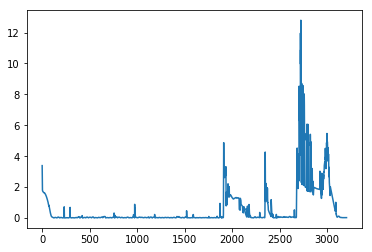

In [33]:
import matplotlib.pyplot as plt
plt.plot(a)

In [10]:
#decay 0.1 0.9 rmsprop optimizer
tf.reset_default_graph()
tf.set_random_seed(2016)
np.random.seed(2016)
batch_num = 1
hidden_num = 15
step_num = 20
elem_num = 385
iteration = 3205

# placeholder list
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]


a=[]
cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
ae = LSTMAutoencoder(hidden_num, p_inputs, cell=cell, decode_without_input=False)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    writer=tf.summary.FileWriter('C:\\Users\\dsba\\Desktop\\NC\\output',sess.graph)
    
    for i in range(iteration):
        input1 =data[i:i+20,]
        input1=input1.reshape([1,20,385])

        summary, loss, _=sess.run([ae.merged, ae.loss, ae.train],  feed_dict={p_input: input1})
        a.append(loss)
        writer.add_summary(summary,i)
        #(loss_val, _) = sess.run([ae.loss, ae.train], {p_input: input1})
                                 
        print('iter %d:' % (i + 1), loss)
    
    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: input1})
    print('train result :')
    print('input :', input_[0, :, :].flatten())
    print('output :', output_[0, :, :].flatten())

iter 1: 2.7266927
iter 2: 2.5938137
iter 3: 5.2654014
iter 4: 2.9747329
iter 5: 2.9595356
iter 6: 2.9442883
iter 7: 2.927992
iter 8: 2.9105122
iter 9: 2.892413
iter 10: 2.8738515
iter 11: 2.8555639
iter 12: 2.84123
iter 13: 2.824799
iter 14: 2.8082278
iter 15: 2.791124
iter 16: 2.7735
iter 17: 2.7551854
iter 18: 2.7374127
iter 19: 2.7182894
iter 20: 2.697753
iter 21: 2.6769116
iter 22: 2.6547568
iter 23: 2.631362
iter 24: 2.606485
iter 25: 2.5807724
iter 26: 2.5536125
iter 27: 2.5261474
iter 28: 2.4972208
iter 29: 2.467883
iter 30: 2.4367726
iter 31: 2.405272
iter 32: 2.368905
iter 33: 2.330484
iter 34: 2.2909079
iter 35: 2.2501905
iter 36: 2.2079253
iter 37: 2.1642027
iter 38: 2.119178
iter 39: 2.073212
iter 40: 2.0261555
iter 41: 1.9768102
iter 42: 1.9268022
iter 43: 1.8795052
iter 44: 1.831952
iter 45: 1.7842795
iter 46: 1.737156
iter 47: 1.6898097
iter 48: 1.6424572
iter 49: 1.594506
iter 50: 1.5454375
iter 51: 1.4960898
iter 52: 1.4464525
iter 53: 1.3952233
iter 54: 1.3425262
iter

iter 429: 0.029414563
iter 430: 0.033142928
iter 431: 0.03550081
iter 432: 0.035626147
iter 433: 0.032882966
iter 434: 0.029675948
iter 435: 0.027193729
iter 436: 0.025195658
iter 437: 0.024320828
iter 438: 0.024919497
iter 439: 0.029969003
iter 440: 0.034262888
iter 441: 0.038227383
iter 442: 0.043020338
iter 443: 0.047729347
iter 444: 0.053386595
iter 445: 0.055027805
iter 446: 0.05595236
iter 447: 0.055156652
iter 448: 0.056079976
iter 449: 0.054094426
iter 450: 0.053170934
iter 451: 0.051056053
iter 452: 0.049079
iter 453: 0.045801975
iter 454: 0.04260955
iter 455: 0.038604315
iter 456: 0.03549293
iter 457: 0.031196969
iter 458: 0.03528463
iter 459: 0.031799003
iter 460: 0.031788725
iter 461: 0.03127821
iter 462: 0.030936886
iter 463: 0.030745396
iter 464: 0.030708365
iter 465: 0.030474605
iter 466: 0.03068649
iter 467: 0.039916825
iter 468: 0.045253623
iter 469: 0.051999457
iter 470: 0.057166692
iter 471: 0.06239224
iter 472: 0.06695731
iter 473: 0.07074501
iter 474: 0.0724612
ite

iter 817: 0.04107569
iter 818: 0.035333756
iter 819: 0.0320536
iter 820: 0.02485381
iter 821: 0.021636756
iter 822: 0.013721324
iter 823: 0.01933858
iter 824: 0.015220595
iter 825: 0.016098008
iter 826: 0.013833844
iter 827: 0.01512231
iter 828: 0.013271401
iter 829: 0.016124114
iter 830: 0.013670326
iter 831: 0.016760366
iter 832: 0.014657572
iter 833: 0.021454632
iter 834: 0.023471173
iter 835: 0.0282362
iter 836: 0.029844312
iter 837: 0.03358519
iter 838: 0.035521854
iter 839: 0.039143708
iter 840: 0.040224142
iter 841: 0.042710073
iter 842: 0.04249674
iter 843: 0.044522192
iter 844: 0.041530192
iter 845: 0.040300462
iter 846: 0.03608148
iter 847: 0.034288194
iter 848: 0.02821229
iter 849: 0.0257609
iter 850: 0.019267676
iter 851: 0.016063876
iter 852: 0.019312598
iter 853: 0.017308285
iter 854: 0.014990094
iter 855: 0.015869716
iter 856: 0.015335847
iter 857: 0.017245192
iter 858: 0.01644166
iter 859: 0.018022275
iter 860: 0.015860068
iter 861: 0.016523859
iter 862: 0.014425188
ite

iter 1194: 0.020614555
iter 1195: 0.023077777
iter 1196: 0.022096526
iter 1197: 0.027777607
iter 1198: 0.022492608
iter 1199: 0.02454723
iter 1200: 0.026300967
iter 1201: 0.028845156
iter 1202: 0.030417997
iter 1203: 0.033099074
iter 1204: 0.03358283
iter 1205: 0.035996746
iter 1206: 0.035242658
iter 1207: 0.037381127
iter 1208: 0.03519807
iter 1209: 0.034871474
iter 1210: 0.031299487
iter 1211: 0.030273613
iter 1212: 0.0271532
iter 1213: 0.02597092
iter 1214: 0.02233908
iter 1215: 0.020317761
iter 1216: 0.018232383
iter 1217: 0.022534622
iter 1218: 0.020583605
iter 1219: 0.021090774
iter 1220: 0.019710489
iter 1221: 0.090849996
iter 1222: 1.2973592
iter 1223: 0.9657001
iter 1224: 0.49597114
iter 1225: 0.8171552
iter 1226: 0.6862877
iter 1227: 0.5689132
iter 1228: 0.45413968
iter 1229: 0.46563444
iter 1230: 0.2979509
iter 1231: 0.2318257
iter 1232: 0.18199125
iter 1233: 0.14418687
iter 1234: 0.11633393
iter 1235: 0.098130286
iter 1236: 0.08355031
iter 1237: 0.07280035
iter 1238: 0.0657

iter 1588: 0.018985279
iter 1589: 0.018275397
iter 1590: 0.01807513
iter 1591: 0.01936807
iter 1592: 0.6512916
iter 1593: 0.50107884
iter 1594: 0.5189633
iter 1595: 1.732857
iter 1596: 0.90235794
iter 1597: 0.5690408
iter 1598: 0.5965897
iter 1599: 0.3088547
iter 1600: 0.25166324
iter 1601: 0.29683706
iter 1602: 0.41222063
iter 1603: 0.22756691
iter 1604: 0.1491739
iter 1605: 0.12786968
iter 1606: 0.10212427
iter 1607: 0.07822087
iter 1608: 0.08251987
iter 1609: 0.058822922
iter 1610: 0.045291536
iter 1611: 0.04306718
iter 1612: 0.04484269
iter 1613: 0.046465643
iter 1614: 0.045189936
iter 1615: 0.043167755
iter 1616: 0.041372202
iter 1617: 0.040241145
iter 1618: 0.039205324
iter 1619: 0.038513236
iter 1620: 0.037814714
iter 1621: 0.037446145
iter 1622: 0.036607936
iter 1623: 0.035603967
iter 1624: 0.03658733
iter 1625: 0.041347705
iter 1626: 0.030932976
iter 1627: 0.02756114
iter 1628: 0.030583916
iter 1629: 0.035694845
iter 1630: 0.04219663
iter 1631: 0.046240196
iter 1632: 0.0496711

iter 1984: 1.6378088
iter 1985: 1.5139271
iter 1986: 1.4448899
iter 1987: 1.3838136
iter 1988: 1.5281074
iter 1989: 2.1345856
iter 1990: 1.2678698
iter 1991: 1.2260131
iter 1992: 1.200314
iter 1993: 1.1600697
iter 1994: 1.1973113
iter 1995: 1.2091533
iter 1996: 0.93325776
iter 1997: 1.2384936
iter 1998: 1.4825561
iter 1999: 1.1790026
iter 2000: 1.4122189
iter 2001: 1.428692
iter 2002: 1.3757467
iter 2003: 2.2645674
iter 2004: 1.9454457
iter 2005: 1.9259422
iter 2006: 1.9230628
iter 2007: 1.9347787
iter 2008: 2.3193989
iter 2009: 2.3092651
iter 2010: 2.2969522
iter 2011: 2.2864778
iter 2012: 2.276321
iter 2013: 2.2635164
iter 2014: 2.2510185
iter 2015: 2.2408428
iter 2016: 2.226585
iter 2017: 2.2136633
iter 2018: 2.1984184
iter 2019: 2.1842165
iter 2020: 2.186118
iter 2021: 2.183727
iter 2022: 2.1865535
iter 2023: 2.182374
iter 2024: 2.1978016
iter 2025: 2.2814672
iter 2026: 2.196812
iter 2027: 2.2287297
iter 2028: 2.23215
iter 2029: 2.2344353
iter 2030: 2.2417736
iter 2031: 2.2479808
i

iter 2380: 0.026077855
iter 2381: 0.02574562
iter 2382: 0.025765603
iter 2383: 0.025457624
iter 2384: 0.02557456
iter 2385: 0.028033867
iter 2386: 0.030972183
iter 2387: 0.03268745
iter 2388: 0.03448455
iter 2389: 0.035329685
iter 2390: 0.036771674
iter 2391: 0.03761879
iter 2392: 0.03718566
iter 2393: 0.03797229
iter 2394: 0.039697792
iter 2395: 0.039406758
iter 2396: 0.039483383
iter 2397: 0.039137952
iter 2398: 0.039877225
iter 2399: 0.037641797
iter 2400: 0.036919452
iter 2401: 0.03531766
iter 2402: 0.03383211
iter 2403: 0.031001776
iter 2404: 0.02904351
iter 2405: 0.028210951
iter 2406: 0.028214702
iter 2407: 0.027479734
iter 2408: 0.027235685
iter 2409: 0.031800717
iter 2410: 0.035973765
iter 2411: 0.039552905
iter 2412: 0.04040744
iter 2413: 0.040714797
iter 2414: 0.040531915
iter 2415: 0.040718455
iter 2416: 0.04445114
iter 2417: 0.047367673
iter 2418: 0.049609978
iter 2419: 0.051872265
iter 2420: 0.05408241
iter 2421: 0.055964094
iter 2422: 0.057555135
iter 2423: 0.059430946
i

iter 2774: 0.02568785
iter 2775: 0.025549557
iter 2776: 0.02548487
iter 2777: 0.02576793
iter 2778: 0.025629215
iter 2779: 0.025343293
iter 2780: 0.024471885
iter 2781: 0.028294502
iter 2782: 0.03145316
iter 2783: 0.03499513
iter 2784: 0.038516656
iter 2785: 0.040991236
iter 2786: 0.04346599
iter 2787: 0.044289216
iter 2788: 0.04558965
iter 2789: 0.045270436
iter 2790: 0.045354635
iter 2791: 0.044197712
iter 2792: 0.044069678
iter 2793: 0.042919174
iter 2794: 0.041502662
iter 2795: 0.038531814
iter 2796: 0.035361584
iter 2797: 0.03160928
iter 2798: 0.027307736
iter 2799: 0.022964658
iter 2800: 0.025193866
iter 2801: 0.02496006
iter 2802: 0.024723427
iter 2803: 0.023552189
iter 2804: 0.022991242
iter 2805: 0.023446687
iter 2806: 0.024257166
iter 2807: 0.024979422
iter 2808: 0.027394477
iter 2809: 0.029431902
iter 2810: 0.030416733
iter 2811: 0.029412365
iter 2812: 0.03182271
iter 2813: 0.033179786
iter 2814: 0.03601742
iter 2815: 0.037835196
iter 2816: 0.039814536
iter 2817: 0.040620815

iter 3156: 0.033595324
iter 3157: 0.033857707
iter 3158: 0.034820456
iter 3159: 0.035618667
iter 3160: 0.03680523
iter 3161: 0.03576616
iter 3162: 0.035256896
iter 3163: 0.033590488
iter 3164: 0.03204576
iter 3165: 0.030505152
iter 3166: 0.029528344
iter 3167: 0.028982641
iter 3168: 0.028974444
iter 3169: 0.02928828
iter 3170: 0.030117111
iter 3171: 0.030810714
iter 3172: 0.031661246
iter 3173: 0.032342535
iter 3174: 0.032705918
iter 3175: 0.032733493
iter 3176: 0.032590535
iter 3177: 0.0320506
iter 3178: 0.031416085
iter 3179: 0.03069264
iter 3180: 0.03023337
iter 3181: 0.029934771
iter 3182: 0.02996275
iter 3183: 0.030121885
iter 3184: 0.030536579
iter 3185: 0.030981291
iter 3186: 0.031491805
iter 3187: 0.031807575
iter 3188: 0.03202253
iter 3189: 0.031946857
iter 3190: 0.031784467
iter 3191: 0.031441245
iter 3192: 0.031130435
iter 3193: 0.03078218
iter 3194: 0.030592674
iter 3195: 0.030462189
iter 3196: 0.030518688
iter 3197: 0.030623702
iter 3198: 0.030864673
iter 3199: 0.031079294

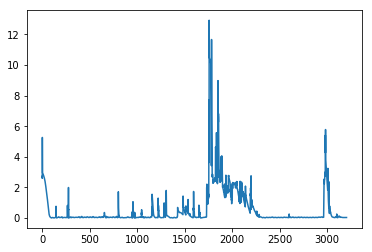

In [12]:
import matplotlib.pyplot as plt
plt.plot(a)

In [21]:
len(input_[:, 0, :].flatten())

385